In [22]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import mpld3
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor

In [108]:
class GPUCB(object):
    
    def __init__(self, meshgrid, environment, beta=1000000.):
        '''
        meshgrid: Output from np.meshgrid.
        e.g. np.meshgrid(np.arrange(-1, 1, 0.1), np.arange(-1, 1, 0.1)) for 2D space
        with |x_i| < 1 constraint.
        environment: Environment class which is equipped with sample() method to return observed value.
        beta (optional): Hyper-parameter to tune the exploration-exploitation balance.
        If beta is large, then it emphasizes the variance of the unexplored solution (i.e. larger curiosity)
        '''
        self.meshgrid = np.array(meshgrid)
        self.environment = environment
        self.beta = beta
        
        self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
        self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
        self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
        self.X = []
        self.T = []
        
    def argmax_ucb(self):
        return np.argmax(self.mu + self.sigma * np.sqrt(self.beta))
    
    def learn(self):
        grid_idx = self.argmax_ucb()
        self.sample(self.X_grid[grid_idx])
        gp = GaussianProcessRegressor()
        gp.fit(self.X, self.T)
        self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
        
    def sample(self, x):
        t = self.environment.sample(x)
        self.X.append(x)
        self.T.append(t)
        
    def plot(self):
        fig = plt.figure(figsize=(8, 4))
        #ax = Axes3D(fig)
        ax = fig.add_subplot(1, 2, 1, projection='3d', aspect='equal')
        # Measured
        ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
                          self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
        # Real
        ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
                          self.environment.sample(self.meshgrid), alpha=0.5, color='b')
        ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
                   marker='o', alpha=1.0)
        ax.set_xlabel = "X[NML]"
        ax.set_ylabel = "Y[NML]"
        #plt.savefig('fig_%02d.png' % len(self.X))
        
        ax = fig.add_subplot(1, 2, 2, aspect='equal')
        ax.plot([x[0] for x in self.X], [x[1] for x in self.X], 'o')
        ax.set_ylim(-10,10)
        ax.set_xlim(-10,10)
        ax.set_xlabel = "X[NML]"
        ax.set_ylabel = "Y[NML]"
        ax.grid()
        plt.show()

In [109]:
class DummyEnvironment(object):
    def sample(self, x):
        return 3 * np.sin(x[0]/3) + 2 * np.cos(x[1]/3)
        #return 3 * np.sin(x[0]/3) + 2 * np.cos(x[1]/3) +0.3*-1*x[0] + 0.3*x[1]

[[3, -3], [3, 0], [3, 3], [0, -3], [0, 0], [0, 3], [-3, -3], [-3, 0], [-3, 3]]
[3.6050175661599688, 4.5244129544236893, 3.6050175661599688, 1.0806046117362795, 2.0, 1.0806046117362795, -1.4438083426874098, -0.52441295442368929, -1.4438083426874098]


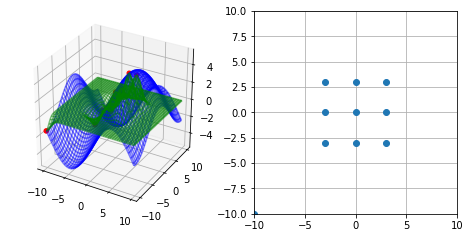

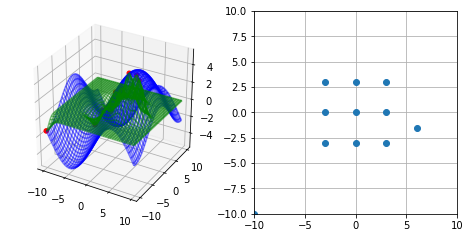

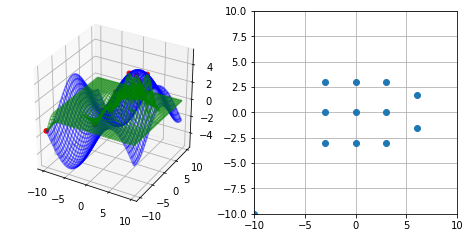

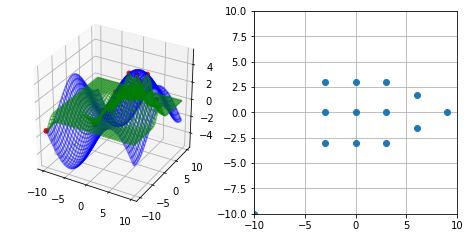

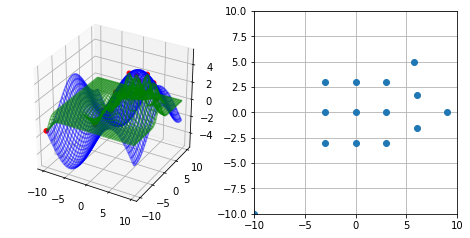

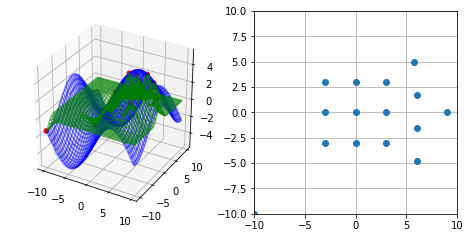

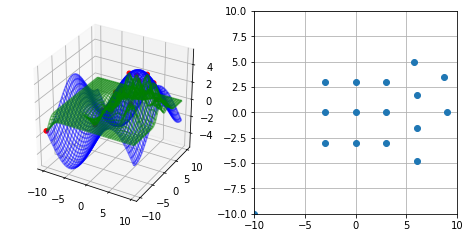

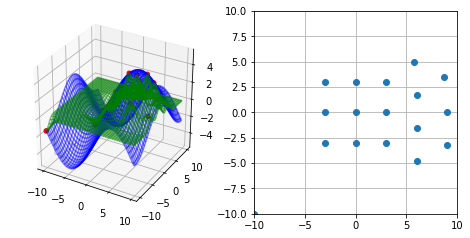

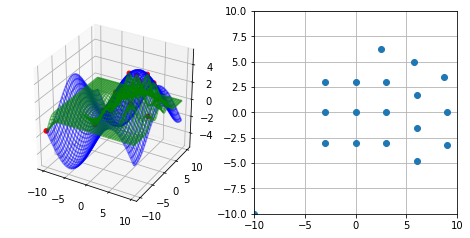

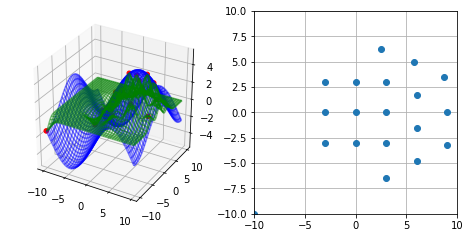

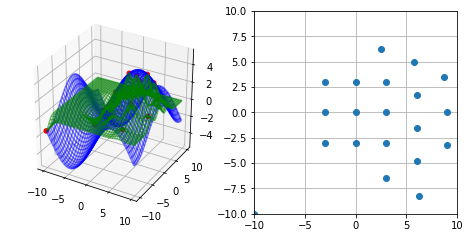

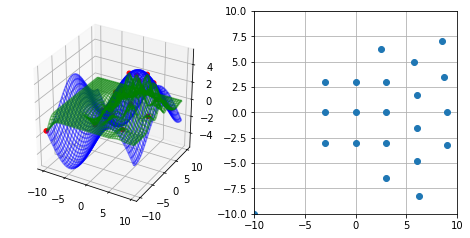

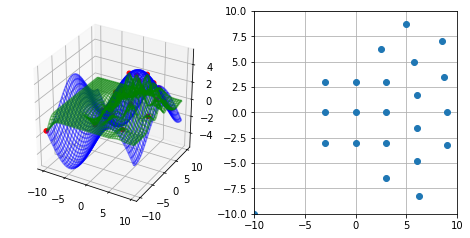

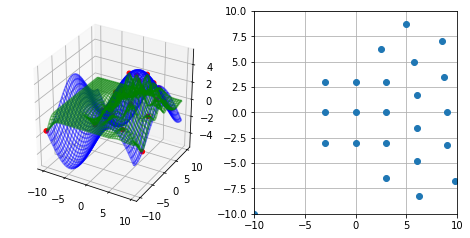

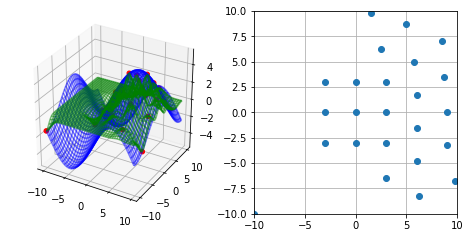

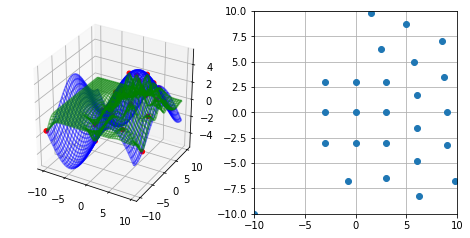

[[3, -3], [3, 0], [3, 3], [0, -3], [0, 0], [0, 3], [-3, -3], [-3, 0], [-3, 3], array([-10., -10.]), array([ 6. , -1.5]), array([ 6.  ,  1.75]), array([ 9.,  0.]), array([ 5.75,  5.  ]), array([ 6.  , -4.75]), array([ 8.75,  3.5 ]), array([ 9.  , -3.25]), array([ 2.5 ,  6.25]), array([ 3. , -6.5]), array([ 6.25, -8.25]), array([ 8.5,  7. ]), array([ 5.  ,  8.75]), array([ 9.75, -6.75]), array([ 1.5 ,  9.75]), array([-0.75, -6.75])]
[3.6050175661599688, 4.5244129544236893, 3.6050175661599688, 1.0806046117362795, 2.0, 1.0806046117362795, -1.4438083426874098, -0.52441295442368929, -1.4438083426874098, -1.3916441207957018, 4.4830574042577904, 4.3971548001403589, 2.4233600241796016, 2.6308951544592372, 2.7028189242360834, 1.4555400015813598, 1.3601318077259024, 1.2397508956315439, 1.4019543288722065, 0.76590481705886937, -0.47131487739618461, 1.0366026388806346, -1.5809326490358033, -0.54998273634848349, -1.9985591232090472]


In [110]:
x = np.arange(-10, 10, 0.25)
y = np.arange(-10, 10, 0.25)
env = DummyEnvironment()
agent = GPUCB(np.meshgrid(x, y), env)
agent.sample([3, -3])
agent.sample([3, 0])
agent.sample([3, 3])
agent.sample([0, -3])
agent.sample([0, 0])
agent.sample([0, 3])
agent.sample([-3, -3])
agent.sample([-3, 0])
agent.sample([-3, 3])
print(agent.X)
print(agent.T)
for i in range(16):
    agent.learn()
    agent.plot()
print(agent.X)
print(agent.T)